## Exercise 1

Set $a=1/2$ and $N=8$ in approximate formula (16),

$$ \langle x | e^{-\tilde{H}T} | x \rangle \approx A\int\limits_{\mathbb{R}^{N-1}}dx_1\dots dx_{N-1}e^{-S_\text{lat}[x]}, $$

where

$$ S_\text{lat}[x] \coloneqq \sum_{j=0}^{N-1}\bigg[ \frac{m}{2a}(x_{j+1}-x_j)^2 + aV(x_j) \bigg], $$

$x_0=x_N=x$, and $a=T/N$, for the propagator, and integrate the right-hand side numerically. The seven dimensional integral that results is easily evaluated using standard rountines, such as vegas. Do this first for the one-dimensional harmonic oscillator potential

$$ V(x) = \frac{x^2}{2}\quad\text{with}\quad m=1.$$

Evaluate the propagator for several values of $x_0=x_N=x$, and compare your results with those of standard quantum mechanics:

$$ \langle x | e^{-\tilde{H}T} | x \rangle \approx |\langle x | E_0 \rangle |^2 e^{-E_0 T}, $$

where $E_0 = 1/2$ and 

$$ \langle x | E_0 \rangle = \frac{e^{-x^2/2}}{\pi^{1/4}}. $$

Extraect the energy and wavefunction from your numerical result. Repeat this exercise for $V(x) = x^4/2$. (If you wish, you may restrict $x$ integrations to the region $-5 \to 5$ rather than $-\infty\to\infty$; this has negligible effect on the results of this exercise.)

## Solution:

Let us start by importing some packages:

In [9]:
begin
    using Cuba # For the vegas routine
    using SpecialFunctions
    using LaTeXStrings
    using LinearAlgebra
    using Plots
    using Test
end

And definig some constants:

In [12]:
const LATTICE_SPACING = 0.5;
const MASS = 1;
const NUMBER_SITES = 8;
const LARGE_TEMPERATURE = LATTICE_SPACING * NUMBER_SITES;

We define the discretized action as a function taking some vector $x$ of length $N-1$, the value at which we evaluate the propagator $x_0 = x_N$, and a potential function $V \colon \mathbb{R} \to \mathbb{R}$. Note that we split the summation loop by separating out the $j=0$ and $j=N-1$ steps to implement the fixed, periodic boundary as 

$$ S_\text{lat}[x] \coloneqq \frac{m}{2a}(x_{1}-x_0)^2 + aV(x_0) +  \sum_{j=1}^{N-2}\bigg[ \frac{m}{2a}(x_{j+1}-x_j)^2 + aV(x_j) \bigg] + \frac{m}{2a}(x_{N}-x_{N-1})^2 + aV(x_{N-1}). $$

Also worth noting that Julia defaults to indexing from 1, so the loop indexing vs actual vector indexing works out to only de-incrementing the end.

In [10]:
function S(x::AbstractVector, x_0::AbstractFloat, V::Function)
    m = MASS
    a = LATTICE_SPACING
    N = NUMBER_SITES
    coef = m / (2*a)

    sum = coef*(x[1] - x_0)^2 + a*V(x_0)
    for j in 1:N-2
        sum += coef*(x[j+1] - x[j])^2 + a*V(x[j])
    end
    sum += coef*(x_0 - x[N-1])^2 + a*V(x[N-1])
    return sum
end

S (generic function with 1 method)

For the harmonic oscillator potential, we numerically integrate the path integral, using the vegas routine provided by Cuba (https://github.com/giordano/Cuba.jl), over a range of values of $x_0 = x_N = x$. Note that Cuba's vegas routine strickly integrates over unit hypercubes, and so we must rescale our functions. Observe that the one-dimensional substitution (just defining a path $p\colon [a,b]\to[0,1]$ such that $p(a)=0$ and $p(b)=1$) $x \to a + (b-a)x$, $dx \to (b-a)dx$ yields the equivalent integrals 

$$ \int\limits_{a}^{b}dx f(x) = \int\limits_{0}^{1}dx(b-a)f(a + (b-a)x).$$

Induction yields 

$$ \int\limits_{[a,b]^{N}}\left(\prod_{j=1}^{N}dx_j\right)f(x_1,\dots,x_N) = \int\limits_{[0,1]^{N}}\left(\prod_{j=1}^{N}dx_j(b-a)\right)f(a+(b-a)x_1,\dots,a+(b-a)x_N)\\
    = \int\limits_{[0,1]^{N}}d\boldsymbol{x}(b-a)^{N}f(a\boldsymbol{e} + (b-a)\boldsymbol{x}), $$

where $\boldsymbol{x} = (x_1,\dots,x_N)$ and $\boldsymbol{e} = (1,\dots,1)$.

The standard result from quantum mechanics we can compare to is

$$ \langle x | e^{-\tilde{H}T}|x\rangle \approx \bigg| \frac{e^{-x^2/2}}{\pi^{1/4}}\bigg|^2 e^{-E_0T} = \frac{e^{-E_0T}}{\sqrt{\pi}}e^{-x^2}.

In [14]:
T = LARGE_TEMPERATURE; E_0 = 0.5;
exact(x) = exp(-E_0*T) * exp(-x^2) / sqrt(π)

exact (generic function with 1 method)

Now we can plot our numerical result and the exact approximation to compare.

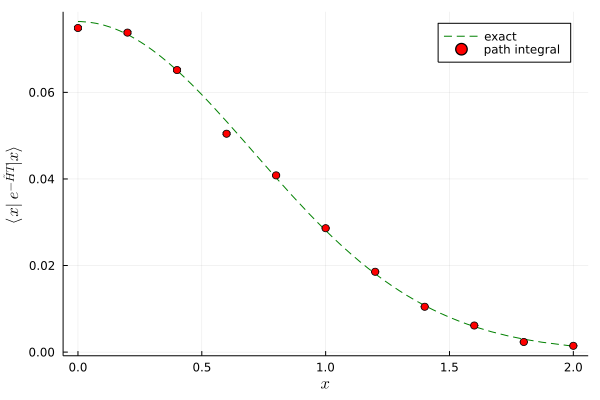

In [24]:
function ExH0()
    V_HO(x) = x^2/2;
    x_numerical = [j for j in 0:0.2:2];
    y_numerical = zeros(length(x_numerical));
    σ_numerical = zeros(length(x_numerical));
    A = (MASS/(2*π*LATTICE_SPACING))^(NUMBER_SITES/2); # Normalization factor
    for j in 1:length(x_numerical) 
        x_0 = x_numerical[j]
        result, err = vegas((x, f) -> f[] = 10^(NUMBER_SITES-1)*exp(-S(-5 .+ 10 .*x,x_0,V_HO)),NUMBER_SITES-1,1)
        y_numerical[j] = result[1] * A
        σ_numerical[j] = err[1] * A
    end
    plot(exact,0,2,label="exact",xlabel=L"x",ylabel=L"\langle x | e^{-\tilde{H}T}|x\rangle",color="green",linestyle=:dash)
    plot!(x_numerical,y_numerical,yerror=σ_numerical, label="path integral", seriestype=:scatter,color="red")
end
ExH0()

This looks pretty reasonable. Let's see how much so. I do not understand the maxevals in vegas; the more it gets the worse it does. For 1e6, 414.4, 1e7, $\chi^2 = 1256.1153147364332$, and $1e8 = 19132.749105861352$.

In [16]:
yx = exact.(x_numerical);
sum = 0;
(y_numerical[1] - yx[1])/σ_numerical[1]
for j in 1:length(x_numerical)
    sum += ((y_numerical[j] - yx[j])/σ_numerical[j])^2
end
println(sum/(length(x_numerical)-1))

414.43451687135456


As we might have expected from the graph, the error bars are indeed too small for this to be a good fit.

Let us extract the energy from this data. From eq. (19), we see that 
$$
    \langle x | e^{-\tilde{H}T} | x \rangle \approx \frac{1}{\sqrt{\pi}} e^{-x^2/2}e^{-E_0T}.
$$
Re-arranging, we find
$$
    e^{-E_0 T} \approx \sqrt{\pi} e^{-x^2/2} \langle x | e^{-\tilde{H}T} | x \rangle.
$$
Hence,
$$
    E_0 \approx - T^{-1}\log(\sqrt{\pi} e^{-x^2/2} \langle x | e^{-\tilde{H}T} | x \rangle).
$$

In [17]:
function extractenergy(x,y)
    f(x) = exp(-x^2) / sqrt(π)

    return - log(sqrt(π)*exp(-x^2/2)*y)/T
end   

extractenergy (generic function with 1 method)

In [18]:
numerical_energies = extractenergy.(x_numerical,y_numerical)

11-element Vector{Float64}:
 0.5049280808973041
 0.5135175333745501
 0.559663174745504
 0.6486363934151312
 0.7365267270730761
 0.8703303368181753
 1.0336601294950398
 1.2416341274322056
 1.450028799774969
 1.7762107149670079
 1.989921739082857

Only the first of these is close to the correct value.

Now we can repeat the exercise for the quartic, anharmonic-oscillator potential.

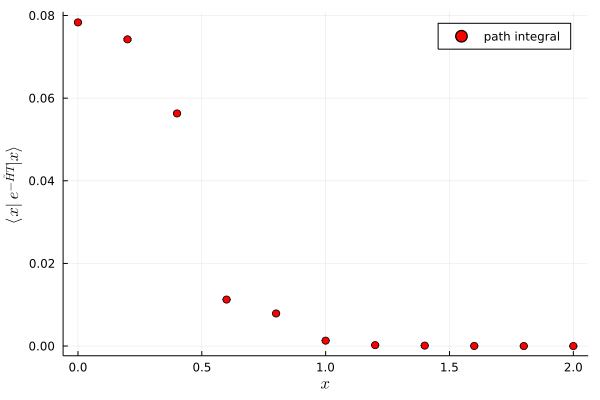

In [27]:
function Ex1AHO()
    V_An(x) = x^4/2;
    x_numerical = [j for j in 0:0.2:2];
    y_numerical = zeros(length(x_numerical));
    σ_numerical = zeros(length(x_numerical));
    A = (MASS/(2*π*LATTICE_SPACING))^(NUMBER_SITES/2); # Normalization factor
    for j in 1:length(x_numerical) 
        x_0 = x_numerical[j]
        result, err = vegas((x, f) -> f[] = 10^(NUMBER_SITES-1)*exp(-S(-5 .+ 10 .*x,x_0,V_An)),NUMBER_SITES-1,1)
        y_numerical[j] = result[1] * A
        σ_numerical[j] = err[1] * A
    end
    plot(x_numerical,y_numerical,yerror=σ_numerical, label="path integral", seriestype=:scatter,color="red",xlabel=L"x",ylabel=L"\langle x | e^{-\tilde{H}T}|x\rangle")
end
Ex1AHO()

## End solution

Some code tests:

In [28]:
@testset "vegas syntax" begin
    N = 10
    result, err = vegas((x, f) -> f[] = exp(-norm(x)^2),N);
    @test result[begin] ≈ π^(N/2)*erf(1)^N/2^N rtol = err[1]*10
    N=9; a = 5 # Integration region over hypercube of sidelength 2a centred about the origin
    # This integration seems to break down around N=9.
    result, err = vegas((x, f) -> f[] = (2*a)^(N)*exp(-norm(-a .+ (2*a).*x)^2),N)
    @test result[begin] ≈ π^(N/2)*erf(a)^(N) rtol = err[1]*10
end

Test Summary: | Pass  Total
vegas syntax  |    2      2


Test.DefaultTestSet("vegas syntax", Any[], 2, false, false)